In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

import missingno as msno
from datetime import date

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [27]:
df = pd.read_csv('/content/US_Accidents_March23_sampled_500k.csv')

In [28]:
# 1. Drop duplicate rows
df.drop_duplicates(inplace=True)

# 2. Drop rows with nulls in key columns
required_columns = ['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng']
df.dropna(subset=required_columns, inplace=True)

# 3. Convert Start_Time and End_Time to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Drop rows where datetime conversion failed
df.dropna(subset=['Start_Time', 'End_Time'], inplace=True)

# 4. Create Duration in minutes
df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60

# Optional: Remove negative or unusually long durations
df = df[df['Duration(min)'] >= 0]
df = df[df['Duration(min)'] <= 1440]  # e.g., remove anything over 24 hours

# Show the first few rows
print(df[['ID', 'Start_Time', 'End_Time', 'Duration(min)', 'Severity']].head())

          ID          Start_Time            End_Time  Duration(min)  Severity
0  A-2047758 2019-06-12 10:10:56 2019-06-12 10:55:58         45.033         2
3  A-4237356 2022-02-21 17:43:04 2022-02-21 19:43:23        120.317         2
4  A-6690583 2020-12-04 01:46:00 2020-12-04 04:13:09        147.150         2
5  A-1101469 2021-03-29 07:03:58 2021-03-29 08:51:01        107.050         2
6  A-7222249 2020-01-14 16:49:23 2020-01-14 20:49:23        240.000         2


In [29]:
df.shape

(450026, 47)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450026 entries, 0 to 499999
Data columns (total 47 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     450026 non-null  object        
 1   Source                 450026 non-null  object        
 2   Severity               450026 non-null  int64         
 3   Start_Time             450026 non-null  datetime64[ns]
 4   End_Time               450026 non-null  datetime64[ns]
 5   Start_Lat              450026 non-null  float64       
 6   Start_Lng              450026 non-null  float64       
 7   End_Lat                229677 non-null  float64       
 8   End_Lng                229677 non-null  float64       
 9   Distance(mi)           450026 non-null  float64       
 10  Description            450025 non-null  object        
 11  Street                 449484 non-null  object        
 12  City                   450011 non-null  object   

In [60]:
#  Convert datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Drop rows where datetime parsing failed
df.dropna(subset=['Start_Time'], inplace=True)

# ========== 1. Date Feature Extraction ==========
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.day_name()

# ========== Rush Hour Analysis ==========
df['Rush_Hour'] = df['Hour'].apply(lambda x: 'Morning' if 6 <= x <= 9
                                   else 'Evening' if 16 <= x <= 19
                                   else 'Other')

# ========== 2. Weather Buckets ==========
def bin_variable(series, bins, labels):
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Temperature
df['Temperature(F)'] = pd.to_numeric(df['Temperature(F)'], errors='coerce')
df['Temp_Level'] = bin_variable(df['Temperature(F)'],
                                bins=[-50, 32, 60, 85, 130],
                                labels=['Freezing', 'Cold', 'Moderate', 'Hot'])

# Humidity
df['Humidity(%)'] = pd.to_numeric(df['Humidity(%)'], errors='coerce')
df['Humidity_Level'] = bin_variable(df['Humidity(%)'],
                                    bins=[0, 30, 60, 100],
                                    labels=['Low', 'Moderate', 'High'])

# Visibility
df['Visibility(mi)'] = pd.to_numeric(df['Visibility(mi)'], errors='coerce')
df['Visibility_Level'] = bin_variable(df['Visibility(mi)'],
                                      bins=[0, 2, 5, 10, 100],
                                      labels=['Very Low', 'Low', 'Moderate', 'High'])

In [32]:
# ========== 3. K-Means Clustering for Hotspot Detection ==========
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

geo_data = df[['Start_Lat', 'Start_Lng']].dropna()
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# Use a small sample to speed up clustering in Kaggle
sample_size = min(100_000, len(geo_scaled))
sample_geo = geo_scaled[np.random.choice(len(geo_scaled), size=sample_size, replace=False)]

# KMeans with 10 clusters (adjust as needed)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
kmeans.fit(sample_geo)

# Predict clusters for all
# Need to align the clusters back to the original df
# Create a temporary dataframe with the scaled data and the original index
geo_scaled_df = pd.DataFrame(geo_scaled, index=geo_data.index)
df['Location_Cluster'] = kmeans.predict(geo_scaled_df)



In [61]:
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
# Replace 'your_features' and 'your_target' with your actual column names
X = df[['Start_Lat', 'Start_Lng', 'Year', 'Month', 'Hour', 'Duration(min)', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Rush_Hour', 'Temp_Level', 'Humidity_Level', 'Visibility_Level', 'Location_Cluster']] # Example features
y = df['Severity'] # Example target variable

# Handle categorical features before splitting if needed or after splitting within preprocessing
# For simplicity here, assuming features are ready or will be handled later

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training data shape: (360020, 26)
Testing data shape: (90006, 26)
Training target shape: (360020,)
Testing target shape: (90006,)


Accuracy: 0.8240117325511632
Precision (macro): 0.709173054628299
Recall (macro): 0.444396969473341
F1 Score (macro): 0.4992851327425664

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.33      0.46       881
           2       0.85      0.95      0.90     69685
           3       0.68      0.43      0.53     17131
           4       0.57      0.07      0.12      2309

    accuracy                           0.82     90006
   macro avg       0.71      0.44      0.50     90006
weighted avg       0.81      0.82      0.80     90006



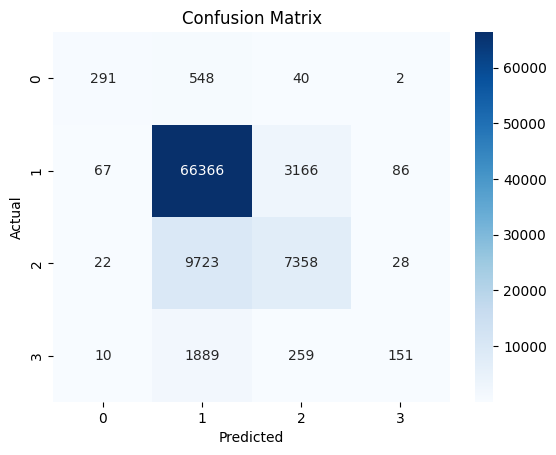

In [66]:
# 1. Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np # Import numpy for numerical types check

# Assuming X and y are already defined and preprocessed up to the point of feature engineering
# before this cell, including the creation of columns like 'Rush_Hour', 'Temp_Level', etc.

# Identify categorical columns that need encoding explicitly by name
categorical_features = ['Rush_Hour', 'Temp_Level', 'Humidity_Level', 'Visibility_Level']

# Identify boolean features explicitly by name
bool_features = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Railway',
                 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# Identify numerical columns - exclude identified categorical and boolean features
all_features = X_train.columns.tolist()
numerical_features = [col for col in all_features if col not in categorical_features and col not in bool_features]

# Create a ColumnTransformer to apply OneHotEncoder to categorical features and handle boolean features
# Boolean features can be passed through as they are typically represented as 0s and 1s
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), # Keep numerical columns as they are
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features), # Apply OneHotEncoder to categorical columns
        ('bool', 'passthrough', bool_features) # Keep boolean columns as they are
    ],
    remainder='passthrough' # Keep any other columns that haven't been explicitly transformed
)

# Create a pipeline that first preprocesses the data and then trains the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

# 2. Split the data (assuming X and y are defined from previous steps)
# This split is already done in a previous cell, but including it here for completeness
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Train the model
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# 6. Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

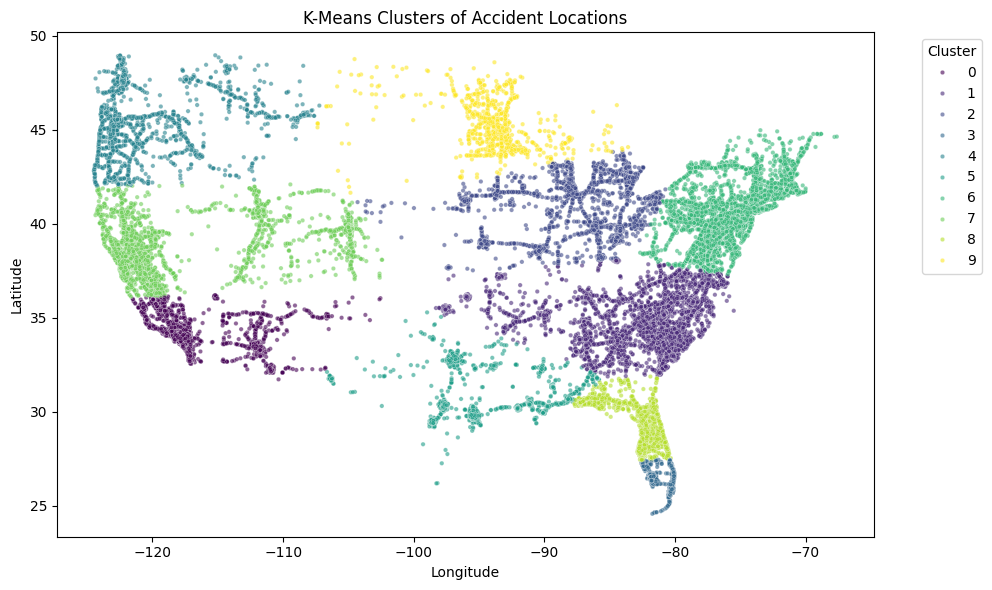

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use the original data with the added 'Location_Cluster' column
# Sample the data if it's too large for plotting
plot_df = df[['Start_Lat', 'Start_Lng', 'Location_Cluster']].dropna().sample(min(100000, len(df)), random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Start_Lng', y='Start_Lat', hue='Location_Cluster', data=plot_df, palette='viridis', s=10, legend='full', alpha=0.6)
plt.title('K-Means Clusters of Accident Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [70]:
# ========== 4. Ensure Boolean Columns ==========
bool_cols = ['Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Railway',
             'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

for col in bool_cols:
    df[col] = df[col].fillna(False).astype(bool)

# Preview processed data
display(df[['Start_Time', 'Year', 'Month', 'Hour', 'Temp_Level', 'Humidity_Level',
    'Visibility_Level', 'Location_Cluster'] + bool_cols].head(10))

,Start_Time,Year,Month,Hour,Temp_Level,Humidity_Level,Visibility_Level,Location_Cluster,Amenity,Bump,Crossing,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2019-06-12 10:10:56,2019,6,10,Moderate,High,Moderate,5,False,False,False,False,False,False,False,False,False,False,True,False
3,2022-02-21 17:43:04,2022,2,17,Freezing,High,Moderate,9,False,False,False,False,False,False,False,False,False,False,False,False
4,2020-12-04 01:46:00,2020,12,1,Cold,Moderate,Moderate,0,False,False,False,False,False,False,False,False,False,False,False,False
5,2021-03-29 07:03:58,2021,3,7,Cold,Moderate,Moderate,6,False,False,False,False,False,False,False,False,False,False,True,False
6,2020-01-14 16:49:23,2020,1,16,Cold,High,Moderate,4,False,False,False,False,False,False,False,False,False,False,False,False
8,2022-10-12 13:59:30,2022,10,13,Hot,Moderate,Moderate,5,False,False,False,False,False,False,False,True,False,False,False,False
9,2021-10-21 07:39:30,2021,10,7,Moderate,High,Moderate,2,False,False,False,False,False,False,False,False,False,False,False,False
10,2021-08-25 07:10:09,2021,8,7,Moderate,High,Moderate,2,False,False,False,False,False,False,False,False,False,False,False,False
11,2022-02-01 04:13:55,2022,2,4,Freezing,High,Moderate,4,False,False,False,False,False,False,False,False,False,False,False,False
12,2020-07-16 11:03:31,2020,7,11,Moderate,High,Moderate,1,False,False,False,False,False,False,False,False,False,False,True,False


<Figure size 1400x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

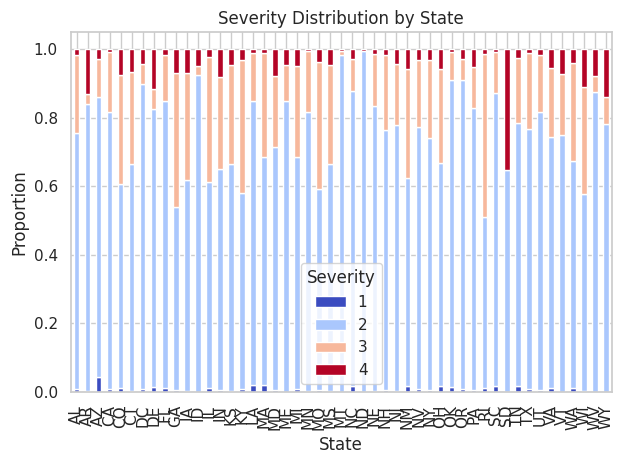

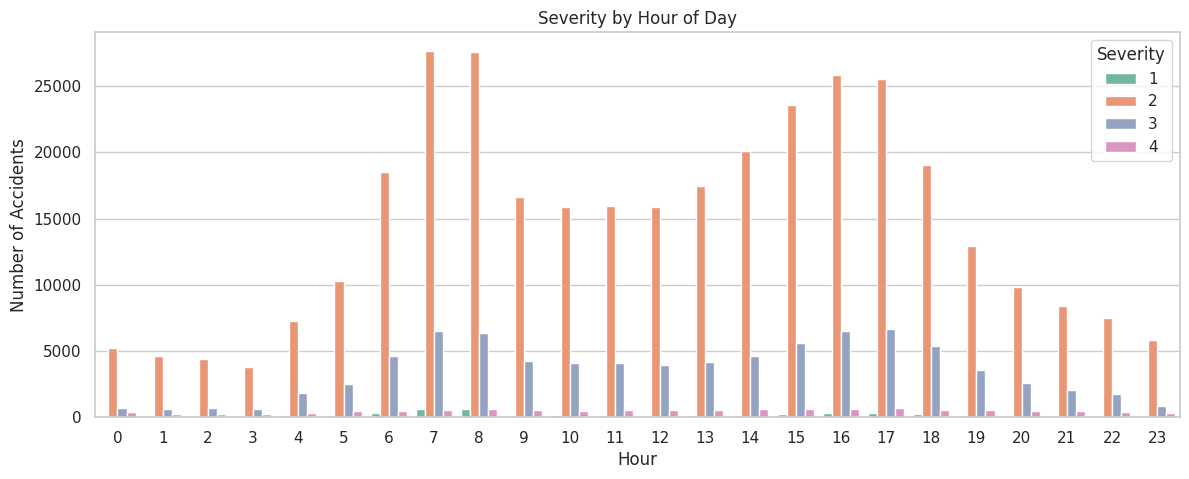

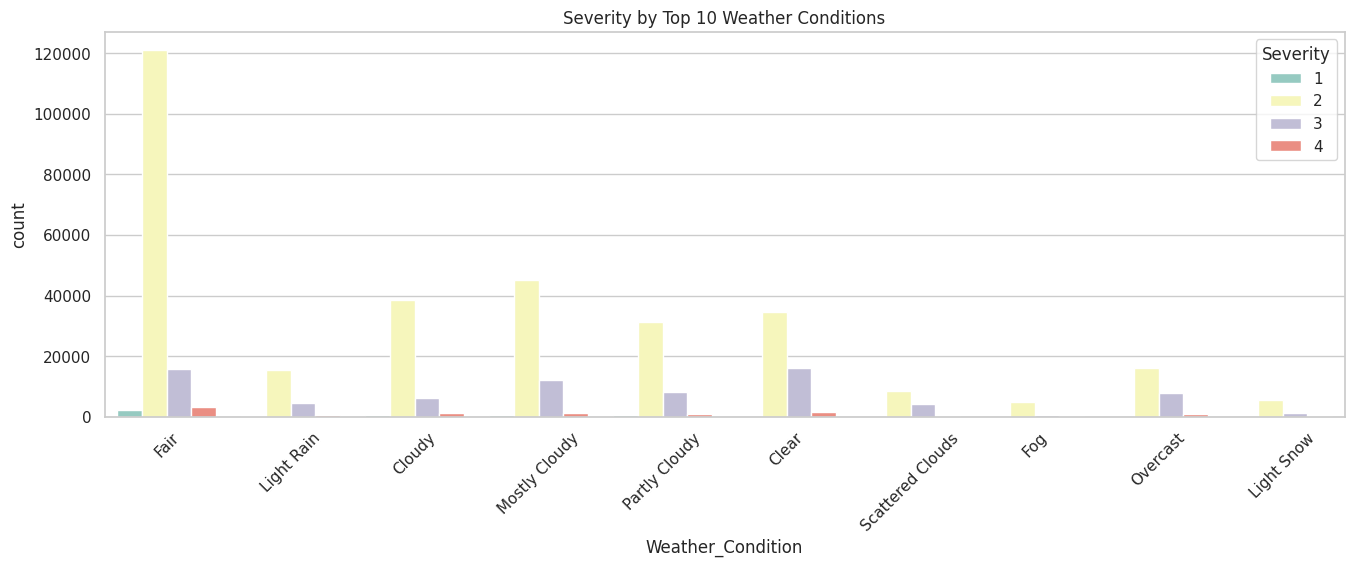

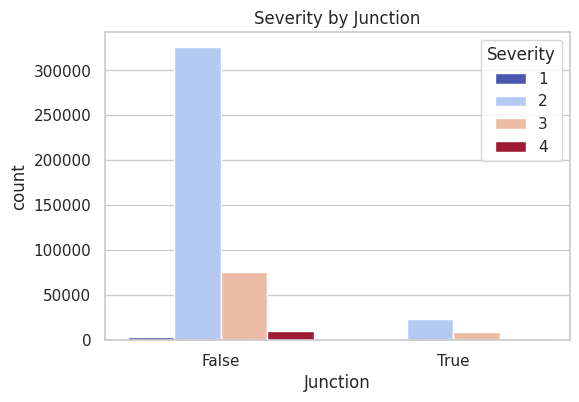

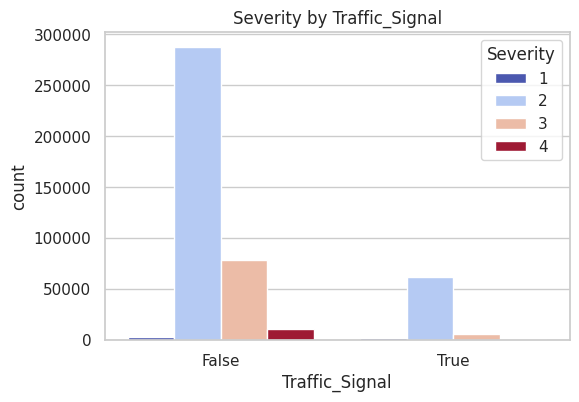

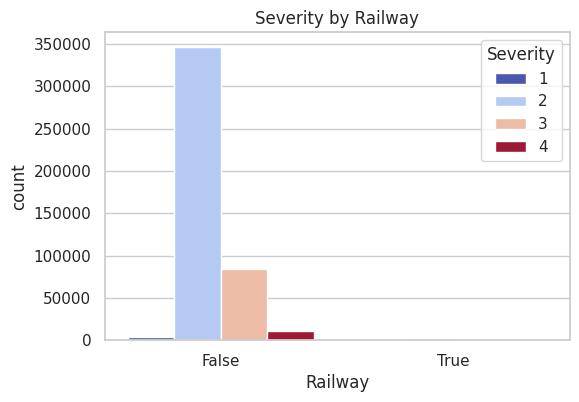

/tmp/ipython-input-71-800664203.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly.index, y=yearly.values, palette='viridis')


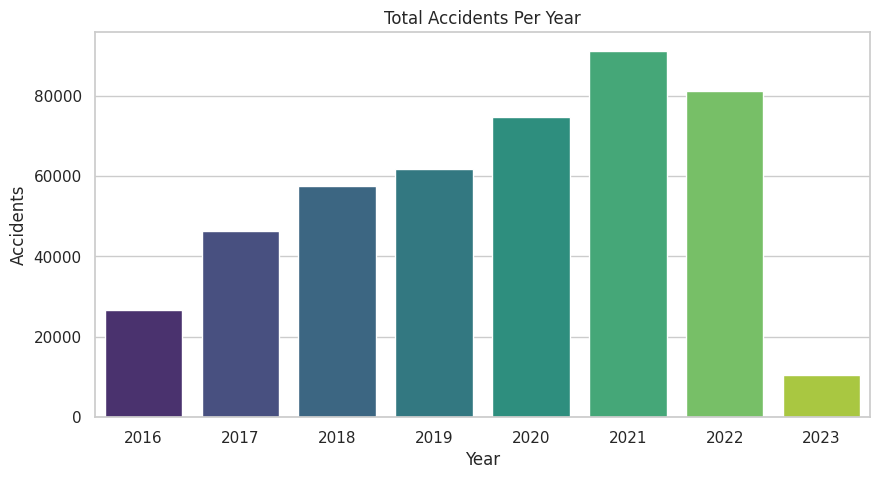

/tmp/ipython-input-71-800664203.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Month', palette='plasma')


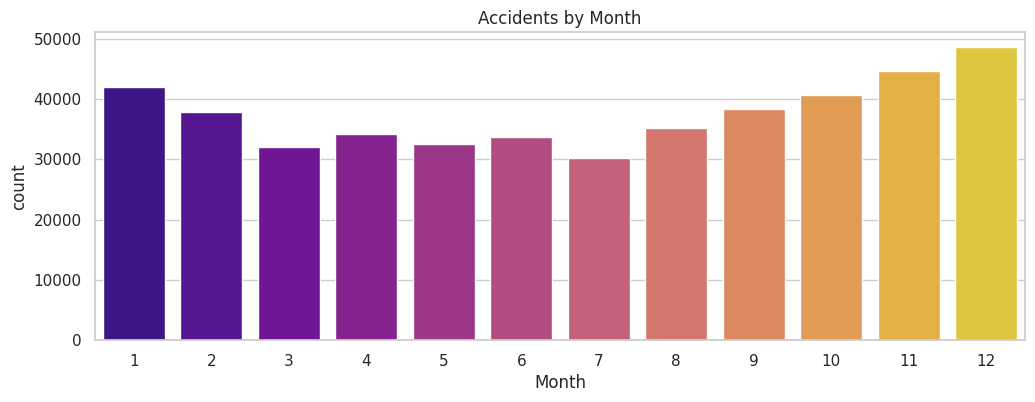

/tmp/ipython-input-71-800664203.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Weekday', order=weekday_order, palette='cubehelix')


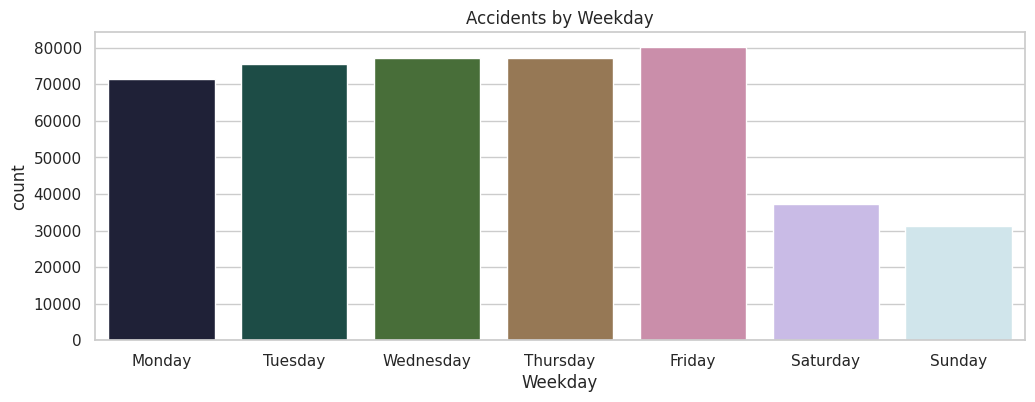

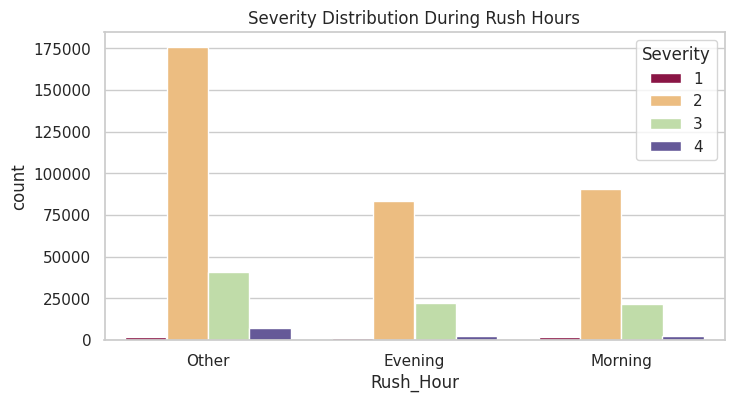

In [71]:
# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# ========== Severity by State ==========
plt.figure(figsize=(16, 6))
state_sev = df.groupby('State')['Severity'].value_counts(normalize=True).unstack().fillna(0)
state_sev.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Severity Distribution by State')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# ========== Severity by Hour ==========
plt.figure(figsize=(14, 5))
sns.countplot(data=df, x='Hour', hue='Severity', palette='Set2')
plt.title('Severity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.show()

# ========== Severity by Weather ==========
plt.figure(figsize=(16, 5))
top_weather = df['Weather_Condition'].value_counts().nlargest(10).index
sns.countplot(data=df[df['Weather_Condition'].isin(top_weather)],
              x='Weather_Condition', hue='Severity', palette='Set3')
plt.title('Severity by Top 10 Weather Conditions')
plt.xticks(rotation=45)
plt.show()

# ========== Severity by Road Features ==========
road_features = ['Junction', 'Traffic_Signal', 'Railway']
for feature in road_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feature, hue='Severity', palette='coolwarm')
    plt.title(f'Severity by {feature}')
    plt.show()

# ========== Accidents Over Years ==========
plt.figure(figsize=(10, 5))
yearly = df['Year'].value_counts().sort_index()
sns.barplot(x=yearly.index, y=yearly.values, palette='viridis')
plt.title('Total Accidents Per Year')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show()

# ========== Accidents by Month ==========
plt.figure(figsize=(12, 4))
sns.countplot(data=df, x='Month', palette='plasma')
plt.title('Accidents by Month')
plt.show()

# ========== Accidents by Weekday ==========
plt.figure(figsize=(12, 4))
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='Weekday', order=weekday_order, palette='cubehelix')
plt.title('Accidents by Weekday')
plt.show()

# ========== Rush Hour Analysis ==========
df['Rush_Hour'] = df['Hour'].apply(lambda x: 'Morning' if 6 <= x <= 9
                                   else 'Evening' if 16 <= x <= 19
                                   else 'Other')

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Rush_Hour', hue='Severity', palette='Spectral')
plt.title('Severity Distribution During Rush Hours')
plt.show()

In [72]:
# Group by state
import plotly.express as px

state_counts = df['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Accident_Count']

# Plot using Plotly
fig = px.choropleth(state_counts,
                    locations='State',
                    locationmode='USA-states',
                    color='Accident_Count',
                    color_continuous_scale='Reds',
                    scope='usa',
                    title='Total Accidents by State (2016–2023)')
fig.show()

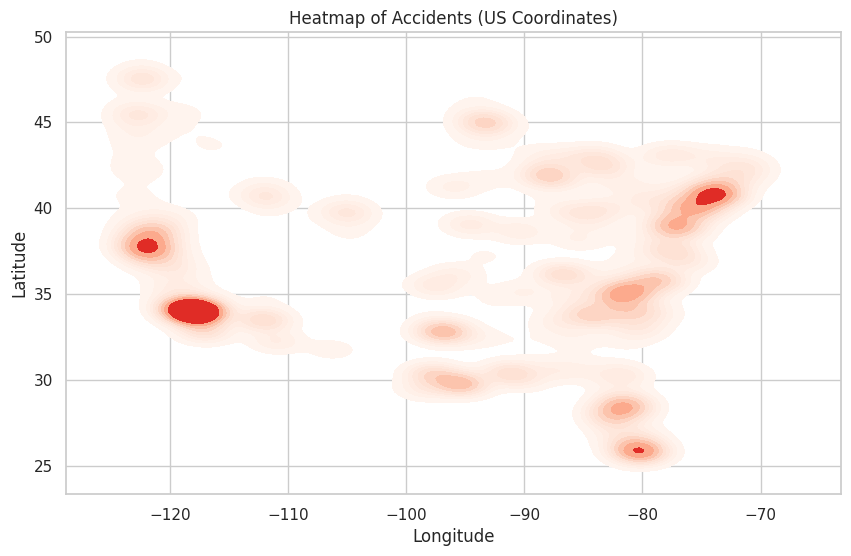

In [79]:
# Sample to make plot efficient
df_sample = df[['Start_Lat', 'Start_Lng']].dropna().sample(min(50000, len(df[['Start_Lat', 'Start_Lng']].dropna())), random_state=42)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_sample, x='Start_Lng', y='Start_Lat', fill=True, cmap='Reds', bw_adjust=0.5)
plt.title('Heatmap of Accidents (US Coordinates)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

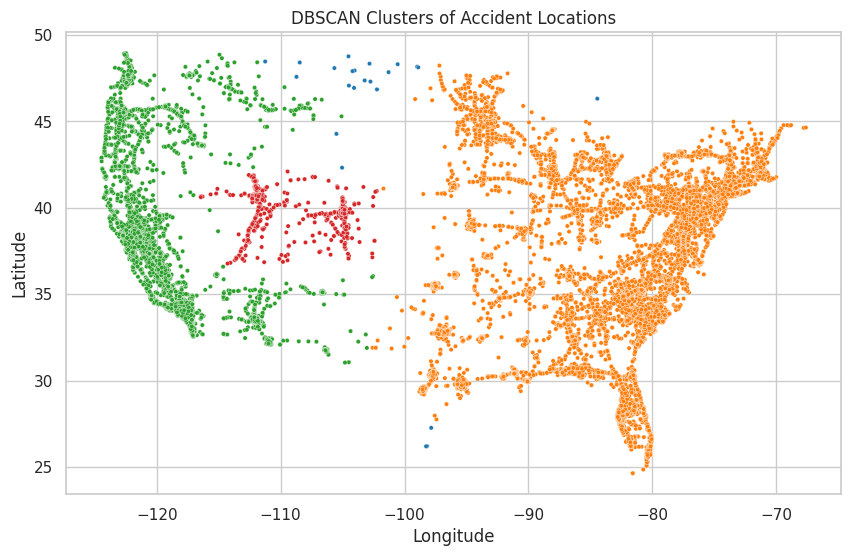

In [73]:
# Prepare data
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

coords = df[['Start_Lat', 'Start_Lng']].dropna().sample(min(50000, len(df[['Start_Lat', 'Start_Lng']].dropna())), random_state=42)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# DBSCAN clustering
db = DBSCAN(eps=0.2, min_samples=50).fit(coords_scaled)
coords['Cluster'] = db.labels_

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Start_Lng', y='Start_Lat', hue='Cluster', data=coords, palette='tab10', s=10, legend=False)
plt.title('DBSCAN Clusters of Accident Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Accuracy: 0.8240117325511632
Precision (macro): 0.709173054628299
Recall (macro): 0.444396969473341
F1 Score (macro): 0.4992851327425664

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.33      0.46       881
           2       0.85      0.95      0.90     69685
           3       0.68      0.43      0.53     17131
           4       0.57      0.07      0.12      2309

    accuracy                           0.82     90006
   macro avg       0.71      0.44      0.50     90006
weighted avg       0.81      0.82      0.80     90006



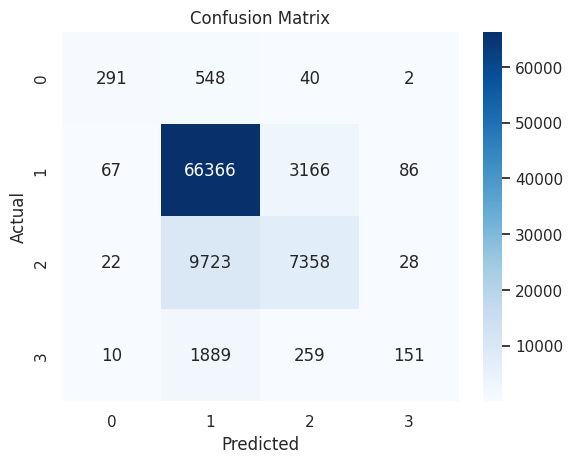

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Example: You must already have y_test and y_pred
# y_test = true labels
# y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 0.8240117325511632
Precision (macro): 0.709173054628299
Recall (macro): 0.444396969473341
F1 Score (macro): 0.4992851327425664

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.33      0.46       881
           2       0.85      0.95      0.90     69685
           3       0.68      0.43      0.53     17131
           4       0.57      0.07      0.12      2309

    accuracy                           0.82     90006
   macro avg       0.71      0.44      0.50     90006
weighted avg       0.81      0.82      0.80     90006



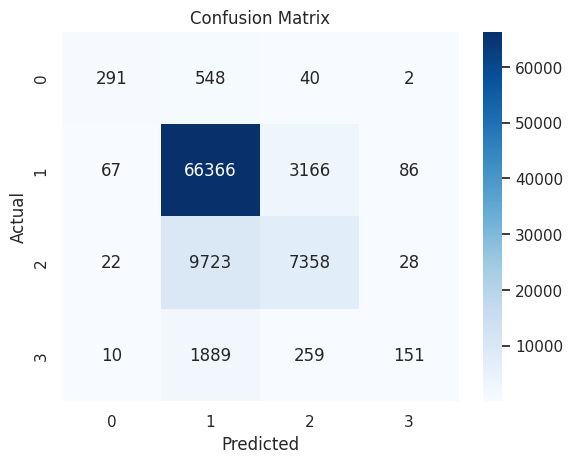

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Example: You must already have y_test and y_pred
# y_test = true labels
# y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [76]:
from sklearn.model_selection import train_test_split

# Define your features (X) and target (y)
# Replace 'your_features' and 'your_target' with your actual column names
X = df[['Start_Lat', 'Start_Lng', 'Year', 'Month', 'Hour', 'Duration(min)', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Amenity', 'Bump', 'Crossing', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Rush_Hour', 'Temp_Level', 'Humidity_Level', 'Visibility_Level', 'Location_Cluster']] # Example features
y = df['Severity'] # Example target variable

# Handle categorical features before splitting if needed or after splitting within preprocessing
# For simplicity here, assuming features are ready or will be handled later

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training data shape: (360020, 26)
Testing data shape: (90006, 26)
Training target shape: (360020,)
Testing target shape: (90006,)


In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical columns that need encoding
categorical_features = ['Rush_Hour', 'Temp_Level', 'Humidity_Level', 'Visibility_Level']
# Identify numerical columns
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features), # Keep numerical columns as they are
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Apply OneHotEncoder to categorical columns
    ])

# Create a pipeline that first preprocesses the data and then trains the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])


# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.824
              precision    recall  f1-score   support

           1       0.76      0.32      0.45       881
           2       0.85      0.95      0.90     69685
           3       0.68      0.43      0.53     17131
           4       0.57      0.07      0.13      2309

    accuracy                           0.82     90006
   macro avg       0.71      0.44      0.50     90006
weighted avg       0.81      0.82      0.80     90006



Accuracy: 0.85679
Precision (macro): 0.7653302837516397
Recall (macro): 0.40516911931305255
F1 Score (macro): 0.44617660057693315

Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.08      0.15       865
           2       0.87      0.96      0.92     79585
           3       0.75      0.51      0.61     16913
           4       0.53      0.06      0.11      2637

    accuracy                           0.86    100000
   macro avg       0.77      0.41      0.45    100000
weighted avg       0.84      0.86      0.84    100000



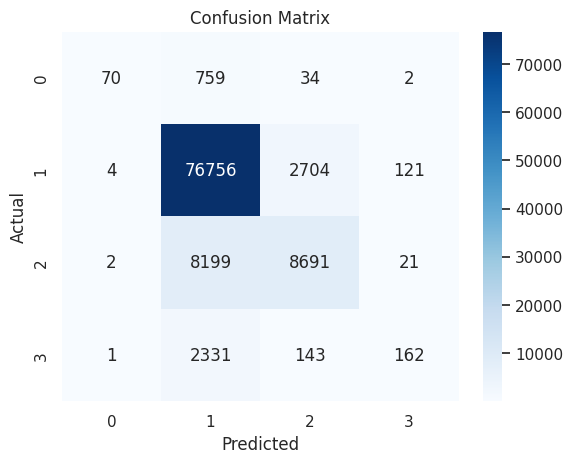

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Extract lat-long for clustering
geo_data = df[['Start_Lat', 'Start_Lng']].dropna()
scaler = StandardScaler()
geo_scaled = scaler.fit_transform(geo_data)

# Optional: sample if dataset is large
sample_size = min(100000, len(geo_scaled))
sample_geo = geo_scaled[np.random.choice(len(geo_scaled), size=sample_size, replace=False)]

# Apply KMeans
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
kmeans.fit(sample_geo)

# Predict cluster for all rows
geo_scaled_df = pd.DataFrame(geo_scaled, index=geo_data.index)
df['Location_Cluster'] = kmeans.predict(geo_scaled_df)

# ========================= STEP 1: Prepare dataset =========================
# Remove the line below that reloads the dataset
# df = pd.read_csv("US_Accidents_March23_sampled_500k.csv")

# Drop rows with missing Severity or Location_Cluster
df_model = df.dropna(subset=['Severity', 'Location_Cluster'])

# Drop unnecessary non-numeric string columns (text or IDs)
drop_cols = ['ID', 'Description', 'Street', 'Number', 'Zipcode', 'Airport_Code', 'Country']
df_model = df_model.drop(columns=[col for col in drop_cols if col in df_model.columns])

# ========================= STEP 2: Split into X and y =========================
X = df_model.drop(columns=['Severity'])
y = df_model['Severity']

# Define columns based on their data type and intended handling
numerical_features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)',
                      'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

categorical_features = ['Source', 'City', 'County', 'State', 'Timezone', 'Wind_Direction',
                        'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
                        'Astronomical_Twilight', 'Location_Cluster'] # Include Location_Cluster as categorical

# Explicitly convert categorical features to 'category' dtype
for col in categorical_features:
    if col in X.columns:
        X[col] = X[col].astype('category')


bool_features = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
                 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

# Ensure all defined feature lists contain only columns present in X
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]
bool_features = [col for col in bool_features if col in X.columns]


# Create a ColumnTransformer with specific handling for each type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features), # Impute numerical NaNs with mean
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                               ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features),
        ('bool', 'passthrough', bool_features) # Boolean columns passed through
    ],
    remainder='drop' # Drop any columns not specified
)


# ========================= STEP 3: Train-test split =========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========================= STEP 4: Model Training =========================
# Create a pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

model.fit(X_train, y_train)

# ========================= STEP 5: Predict and Evaluate =========================
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [91]:
# Inspect data types of categorical features in X_train
print("Data types of categorical features in X_train:")
print(X_train[categorical_features].dtypes)

# Inspect unique values of categorical features in X_train
print("\nUnique values of categorical features in X_train:")
for col in categorical_features:
    print(f"- {col}: {X_train[col].unique()}")

Data types of categorical features in X_train:
Source                   category
City                     category
County                   category
State                    category
Timezone                 category
Wind_Direction           category
Weather_Condition        category
Sunrise_Sunset           category
Civil_Twilight           category
Nautical_Twilight        category
Astronomical_Twilight    category
Location_Cluster         category
dtype: object

Unique values of categorical features in X_train:
- Source: ['Source1', 'Source2', 'Source3']
Categories (3, object): ['Source1', 'Source2', 'Source3']
- City: ['Beaver Falls', 'Raleigh', 'Lebec', 'Colorado Springs', 'Old Fort', ..., 'Osyka', 'Gales Ferry', 'Dunkerton', 'Brush Creek', 'Kents Store']
Length: 9053
Categories (9488, object): ['Aaronsburg', 'Abbeville', 'Abbotsford', 'Abbott', ..., 'Zumbro Falls', 'Zumbrota', 'Zuni', 'Zwingle']
- County: ['Beaver', 'Wake', 'Los Angeles', 'El Paso', 'Polk', ..., 'Mcminn', 'Kleber